In [1]:
from comet_ml import Experiment
from comet_ml import OfflineExperiment
from matplotlib.pyplot import cla
from sklearn.model_selection import cross_validate
from loader import numerical_loader
import numpy as np
import lightgbm as lgb
from cfg import *
from sklearn.feature_selection import SelectPercentile, chi2, mutual_info_classif
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from train import run

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


Number of Patients and feature : 57 16
Number of Case 1 and Case 2 : 44 13
-------------------------
Using feature:
Index(['Gender (M:1 F:0)', 'ADC tumor', 'GTR', 'STR',
       'Peritumoral edema (Yes:1 or No:1)',
       'Heterogeneous enhancement (Yes:1 or No:0)', 'Calcification',
       'Dural tail sign', 'Maximal diameter', 'Tumor volume (cm3)', 'x', 'y',
       'z', 'Simpson grade resection_1', 'Simpson grade resection_3',
       'Simpson grade resection_4'],
      dtype='object')
-------------------------
accuracy : 0.8582828282828283
precision : 0.851111111111111
recall : 0.49333333333333335
roc_auc : 0.7282407407407406


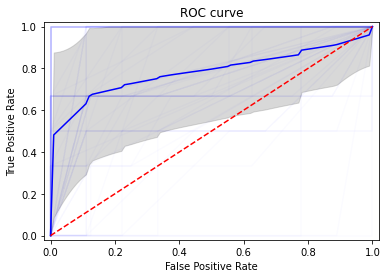

In [2]:
lgbmclf = lgb.LGBMClassifier(
   boosting_type='dart',
   learning_rate=.01,
   min_child_samples=5,
   max_depth=-1,
   num_leaves=11,
   objective='binary',
   n_estimators=30,
   class_weight='balanced'
)
clf = Pipeline([
    ('selector', SelectPercentile(feature_selection.f_classif, percentile=75)), 
    ('lgb', lgbmclf)
])
base_fpr = np.linspace(0, 1, 101)
tprs = []
imp = np.array([0]*12)

if __name__=='__main__':
        experiment = OfflineExperiment(
        api_key=COMET_APT_KEY,
        project_name=COMET_PROJECT_NAME,
        workspace=COMET_WORK_SPACE,
        display_summary_level=0,
        disabled=True,
        )    
        experiment.add_tag('Num')
        df, y_df  = numerical_loader()
        
        met = [ 'accuracy', 'precision', 'recall', 'roc_auc']
        metric = ['train_' + val for val in met] + ['test_' + val for val in met]
        
        total_result = {}
        for m in metric: total_result[m] = []

        for i in range(NUM_RANDOM_STATE):
                result = run(df, y_df, clf, seed=SEEDS[i], prob=True, thr=.6, feature_imp=imp, slow_imp=True
                )                        # ros=True

                for m in metric: total_result[m].append(result[m])
                
                for j in range(len(result['test_fpr'])):
                        plt.plot(result['test_fpr'][j], result['test_tpr'][j], 'b', alpha=0.015)
                        tpr = np.interp(base_fpr, result['test_fpr'][j], result['test_tpr'][j])
                        tpr[0] = 0.0
                        tprs.append(tpr)
        for m in met:  
                experiment.log_metric(m, np.mean(result[f'test_{m}']))
                print(m, ':', np.mean(total_result[f'test_{m}'])) 
        tprs = np.array(tprs)        
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)

        tprs_upper = np.minimum(mean_tprs + std, 1)
        tprs_lower = mean_tprs - std
        plt.plot(base_fpr, mean_tprs, 'b')
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
        plt.xlim([-0.02, 1.02])
        plt.ylim([-0.02, 1.02])
        plt.plot([0, 1], [0, 1],'r--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.title('ROC curve')        
        plt.show()
experiment.end()

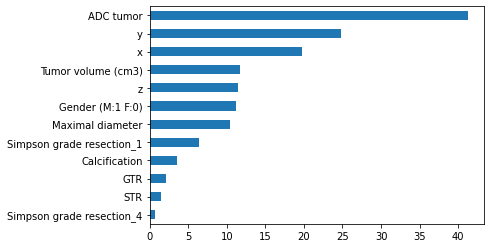

In [3]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
cols = ['Gender (M:1 F:0)', 'ADC tumor', 'GTR', 'STR',
       'Peritumoral edema (Yes:1 or No:1)',
       'Heterogeneous enhancement (Yes:1 or No:0)', 'Calcification',
       'Dural tail sign', 'Maximal diameter', 'Tumor volume (cm3)', 'x', 'y',
       'z', 'Simpson grade resection_1', 'Simpson grade resection_3',
       'Simpson grade resection_4']
mask =clf['selector'].get_support()
cols  = [cols[i] for i in range(len(cols)) if mask[i]]
pd.Series(imp/75, index=cols).sort_values().plot(kind='barh')